# <center> Residential Power Usage (3 years data) </center>
----
Data obtained from: https://www.kaggle.com/datasets/srinuti/residential-power-usage-3years-data-timeseries?select=power_usage_2016_to_2020.csv

Goals:
- Analyze residential power usage trend
- Study the residential power usage and weather relationship
- Forecast residential power usage 






In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import statistics as stat

from plotly.subplots import make_subplots
from inflection import underscore
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf


In [2]:
##### Functions used in notebook

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])





---
# Import data and change the column names case

---

In [2]:
power_df = pd.read_csv("power_usage_2016_to_2020.csv")
power_df.columns = [underscore(val) for val in power_df.columns]

# weather_df = pd.read_csv("weather_2016_2020_daily.csv")
# weather_df.columns = [underscore(val) for val in weather_df.columns]


----
# Data Wrangling

---

In [3]:
##### convert column to specific type
power_df["start_date"] = pd.to_datetime(power_df["start_date"])
power_df["power_date"] = power_df["start_date"].dt.date

# weather_df["date"] = pd.to_datetime(weather_df["date"])
# weather_df = weather_df.rename(columns={"date":"weather_date"})

# ##### sort data according to date
# power_df = power_df.sort_values("power_date")
# weather_df = weather_df.sort_values("weather_date")

# ##### some power usage based on date
# daily_power = power_df.groupby("power_date").sum(numeric_only=True).asfreq(freq="1d").reset_index()
# daily_power["power_date"] = pd.to_datetime(daily_power["power_date"])
# daily_power["day_name"] = daily_power["power_date"].dt.day_name()
# daily_power["power_day"] = daily_power["power_date"].dt.day
# daily_power["month"] = daily_power["power_date"].dt.month
# daily_power["year"] = daily_power["power_date"].dt.year
# daily_power["week"] = [daily_power.loc[val, "power_date"].week for val in range(len(daily_power))]
# daily_power

# ##### modification on weather_df
# weather_df = weather_df.set_index("weather_date").asfreq(freq="1d").reset_index()
# weather_df["weather_date"] = pd.to_datetime(weather_df["weather_date"])
# weather_df.loc[:, "day"] = weather_df["weather_date"].dt.day


# ##### join daily_power and weather_df
# power_weather = weather_df.merge(daily_power[["value (k_wh)", "power_date", "day_name", "month", "week", "year"]], 
#                                  left_on="weather_date", right_on="power_date", how="right")


# ###### select data from July 1, 2016 to June 30, 2020
# ######  - a lot of missing data for power_date < 2016-07-01 and power_date >= 2016-07-01
# ###### drop these data
# power_weather = power_weather[(power_weather["power_date"]>="2016-07-01") & (power_weather["power_date"]<="2020-06-30")]

# ##### fill NaN data with some values
# ##### these are applicable to some rows between 2016-07-01 and 2020-06-30
# power_weather = power_weather.fillna(power_weather.rolling(7,min_periods=1, center=True).mean(numeric_only=True))




---
# Time Plots

---


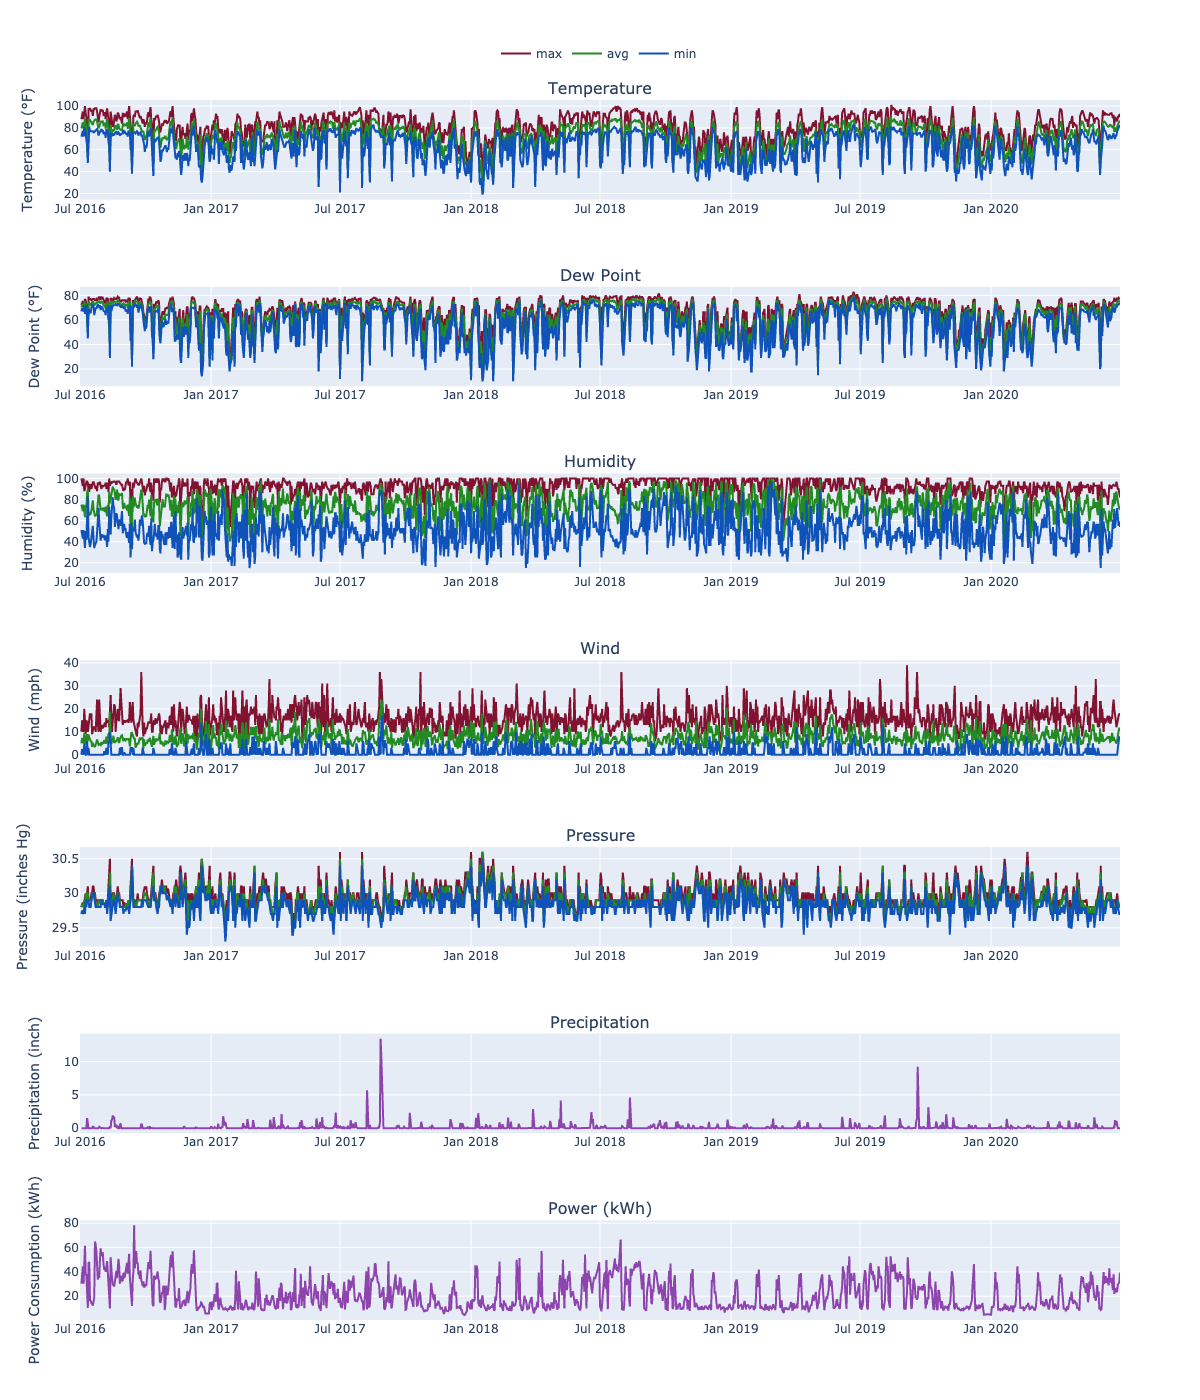

In [7]:
power_weather_cols = ['temp_max', 'temp_avg', 'temp_min', 'dew_max', 'dew_avg', 'dew_min', 'hum_max', 'hum_avg', 'hum_min',
                      'wind_max', 'wind_avg', 'wind_min', 'press_max', 'press_avg', 'press_min', 'precipit', 'value (k_wh)',]

fig_1 = make_subplots(rows=7, cols=1, 
                      subplot_titles=["Temperature", "Dew Point", "Humidity", "Wind", "Pressure",
                                      "Precipitation", "Power (kWh)"])

ind = 0
col_n = ""

color_dict = {"min": "#0F52BA", "avg": "#228B22", "max": "#811331", "others": "#8E44AD"}


for ii in range(len(power_weather_cols)):

    col = power_weather_cols[ii]
    col_split = col.split("_")

    if (len(col_split)>1) and (col_split[1] in color_dict.keys()):
        color = color_dict[col_split[1]]
        group_title = col_split[1]
    else:
        color = color_dict["others"]
        group_title = col


    if col_n != col_split[0]:
        col_n = col_split[0]
        ind = ind + 1

        fig_1.add_trace(
            go.Scatter(x=power_weather["weather_date"], y=power_weather[col], 
                       line=dict(color=color), showlegend=True if (ii<3) else False,
                       legendgroup=group_title, name=group_title
                       ),
            row=ind,
            col=1
        )
    
    else:

        fig_1.add_trace(
            go.Scatter(x=power_weather["weather_date"], y=power_weather[col], 
                       line=dict(color=color), showlegend=True if (ii<3) else False,
                       legendgroup=group_title, name=group_title
                       ),
            row=ind,
            col=1
        )


fig_1.update_yaxes(title_text="Temperature (\xb0F)", row=1)
fig_1.update_yaxes(title_text="Dew Point (\xb0F)", row=2)
fig_1.update_yaxes(title_text="Humidity (%)", row=3)
fig_1.update_yaxes(title_text="Wind (mph)", row=4)
fig_1.update_yaxes(title_text="Pressure (inches Hg)", row=5)
fig_1.update_yaxes(title_text="Precipitation (inch)", row=6)
fig_1.update_yaxes(title_text="Power Consumption (kWh)", row=7)


fig_1.update_layout(height=1400, width=1200,
                    legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.4, orientation="h"))
fig_1.show(renderer="png")



---
# Average (or Sum) of Power Consumptions at Different Granularity

---

In [9]:
"""
grouping at different granularity: hourly, daily, weekly, monthly, and yearly
* hourly: take average directly since the data are already at hourly granularity
* daily: sum the hourly data according to date, followed by average by day
* weekly: sum the daily data into weekly data then average by week
* monthly: sum the daily data into monthly data, then average by month
* yearly: sum to the daily data into yearly data
"""

hourly_average = power_df[["start_date", "value (k_wh)"]].copy()
hourly_average.loc[:, "hour"] = hourly_average["start_date"].dt.hour
hourly_average = hourly_average.groupby("hour").mean().reset_index()

daily_average = power_weather[["day", "value (k_wh)"]].groupby("day").mean(numeric_only=True).reset_index()
daily_average

daily_name_average = power_weather[["day_name", "value (k_wh)"]].groupby("day_name").mean(numeric_only=True)
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_name_average = daily_name_average.reindex(day_names).reset_index()
daily_name_average

weekly_average = daily_power.groupby(["year", "month", "week"]).sum(numeric_only=True).reset_index()
weekly_average = weekly_average[["week", "value (k_wh)"]].groupby("week").mean().reset_index()
weekly_average

monthly_average = daily_power.groupby(["year", "month"]).sum(numeric_only=True).reset_index()
monthly_average = monthly_average[["month", "value (k_wh)"]].groupby("month").mean().reset_index()
monthly_average

yearly_average = daily_power.groupby(["year"]).sum(numeric_only=True).reset_index()
yearly_average



year  value (k_wh)  day_of_week  power_day  month  week
0  2016   6649.682600      15312.0       5752   2379  9592
1  2017   6733.161951      26352.0       5738   2382  9698
2  2018   8051.672900      26208.0       5738   2382  9647
3  2019   7272.962833      26232.0       5738   2382  9647
4  2020   3348.443429      13656.0       5292   2084  8573

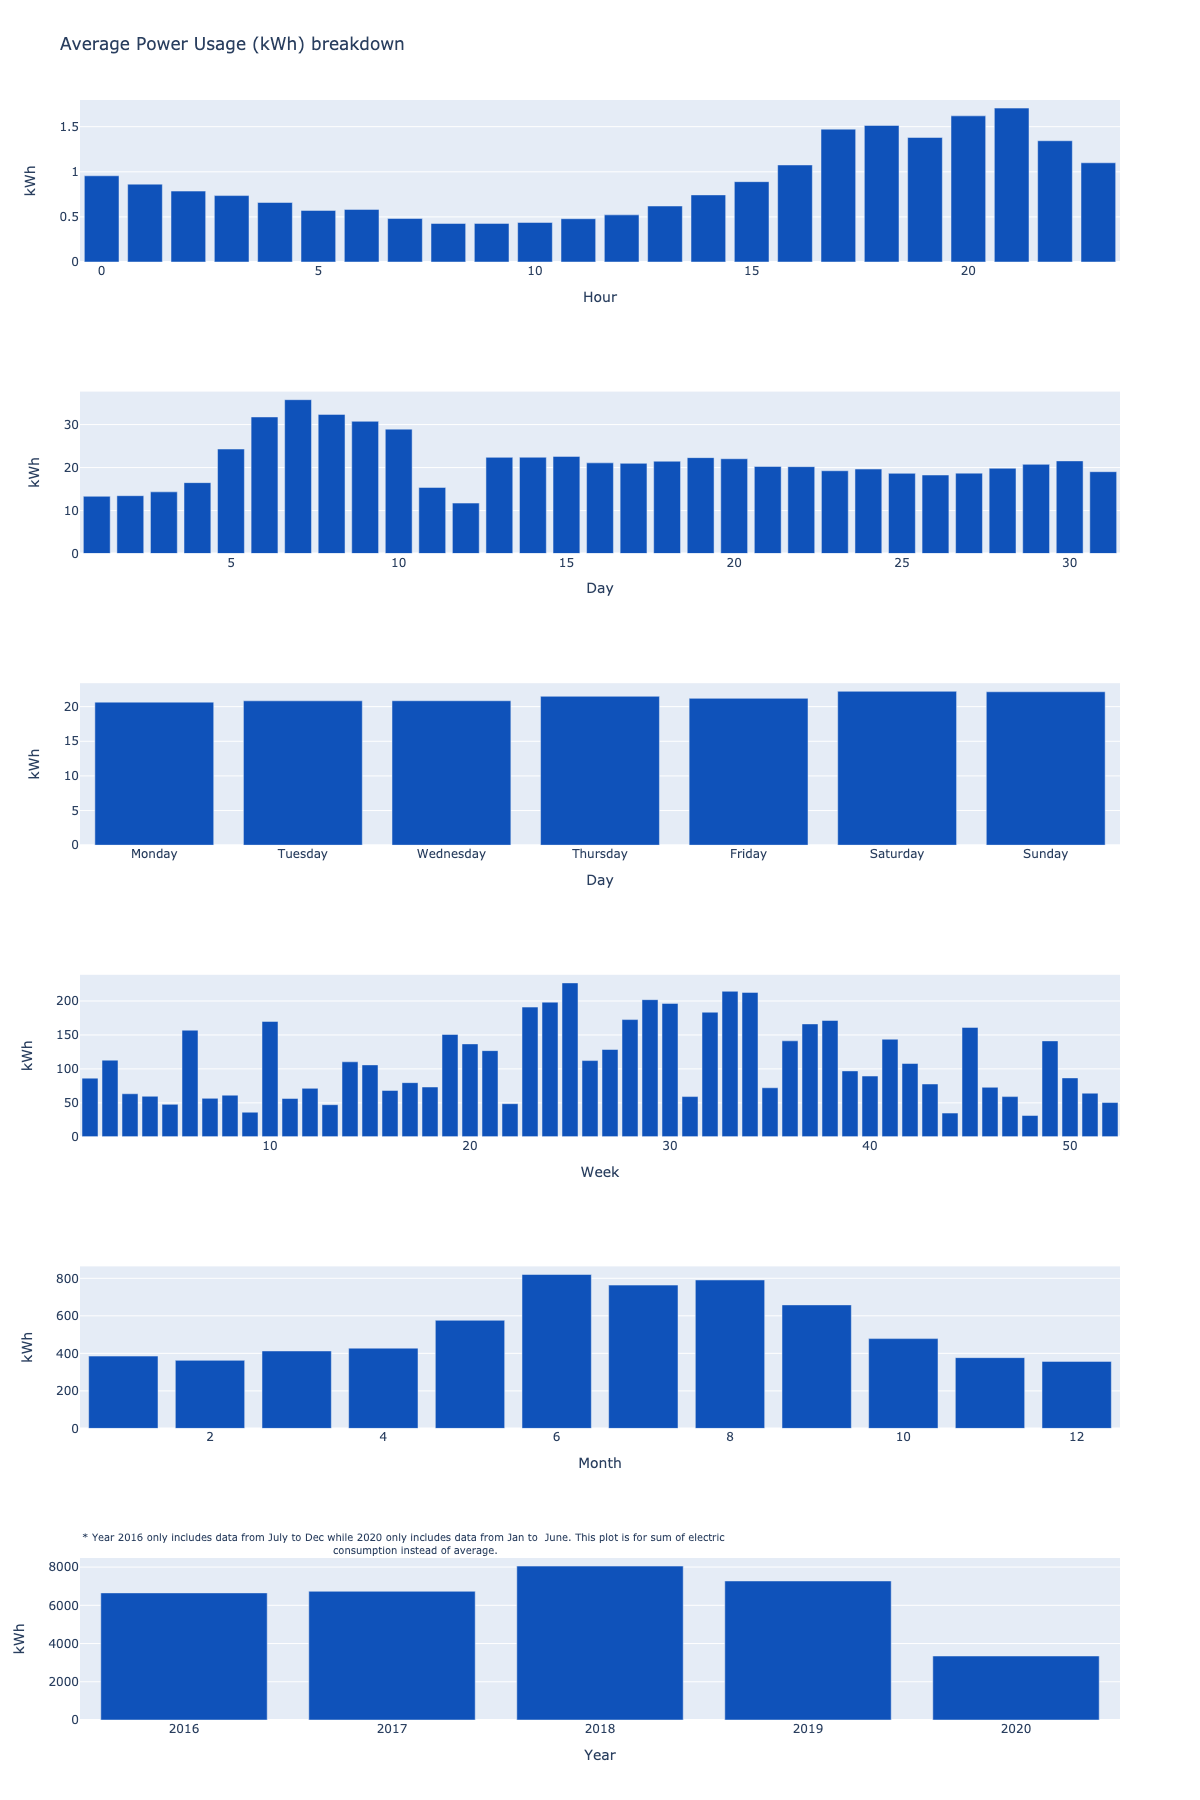

In [10]:
fig_1 = make_subplots(rows=6, cols=1, vertical_spacing=0.08)

fig_1.add_trace( go.Bar(x=hourly_average["hour"], y=hourly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=1, col=1)

fig_1.add_trace( go.Bar(x=daily_average["day"], y=daily_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=2, col=1)

fig_1.add_trace( go.Bar(x=daily_name_average["day_name"], y=daily_name_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=3, col=1)

fig_1.add_trace( go.Bar(x=weekly_average["week"], y=weekly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=4, col=1)

fig_1.add_trace( go.Bar(x=monthly_average["month"], y=monthly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=5, col=1)

fig_1.add_trace( go.Bar(x=yearly_average["year"], y=yearly_average["value (k_wh)"],
                        marker=dict(color="#0F52BA")),
                row=6, col=1)



fig_1.update_xaxes(title_text="Hour", row=1)
fig_1.update_xaxes(title_text="Day", row=2)
fig_1.update_xaxes(title_text="Day", row=3)
fig_1.update_xaxes(title_text="Week", row=4)
fig_1.update_xaxes(title_text="Month", row=5)
fig_1.update_xaxes(title_text="Year", row=6)

fig_1.update_yaxes(title_text="kWh")


fig_1.update_layout(height=1200, width=800, showlegend=False, title_text="Average Power Usage (kWh) breakdown")
fig_1.add_annotation(
    text="""* Year 2016 only includes data from July to Dec while 2020 only includes data from Jan to  June. This plot is for sum of electric 
    <br> consumption instead of average.""",
    font=dict(size=10),
    xref="paper", yref="paper",
    x=0, y=0.1,
    showarrow=False
)

fig_1.update_layout(height=1800, width=1200)
fig_1.show(renderer="png")



At hourly level, the average power consumption is the highest in the evening between 5 pm to 11 pm. This might be cause by people are back in their home after and they have their daily activities such as cooking, watching tv, and doing laundry. The power consumption starts to go down from 10 pm onwards presumably because people are starting to go to bed.

At daily level, there's a peak power consumption 6th to 8th day of the month. This peak is currently still under investigation. If the average power consumption was taken based on the name of the day, there's no peak appeared, which indicates that the amount of power consume during the week stays relatively the same.

At weekly level, there were apparent patterns in the power consumption. The huge power consumptions at 6th, 10th, 25th, and others are still under investigation.

At monthly level, the power consumption was the highest between June and August. This observation could be realted to the summer months where the temperatures are high. Consequently, people will consume a lot of power to cool down their house.

---
# Power Consumption and Weather Correlation

---

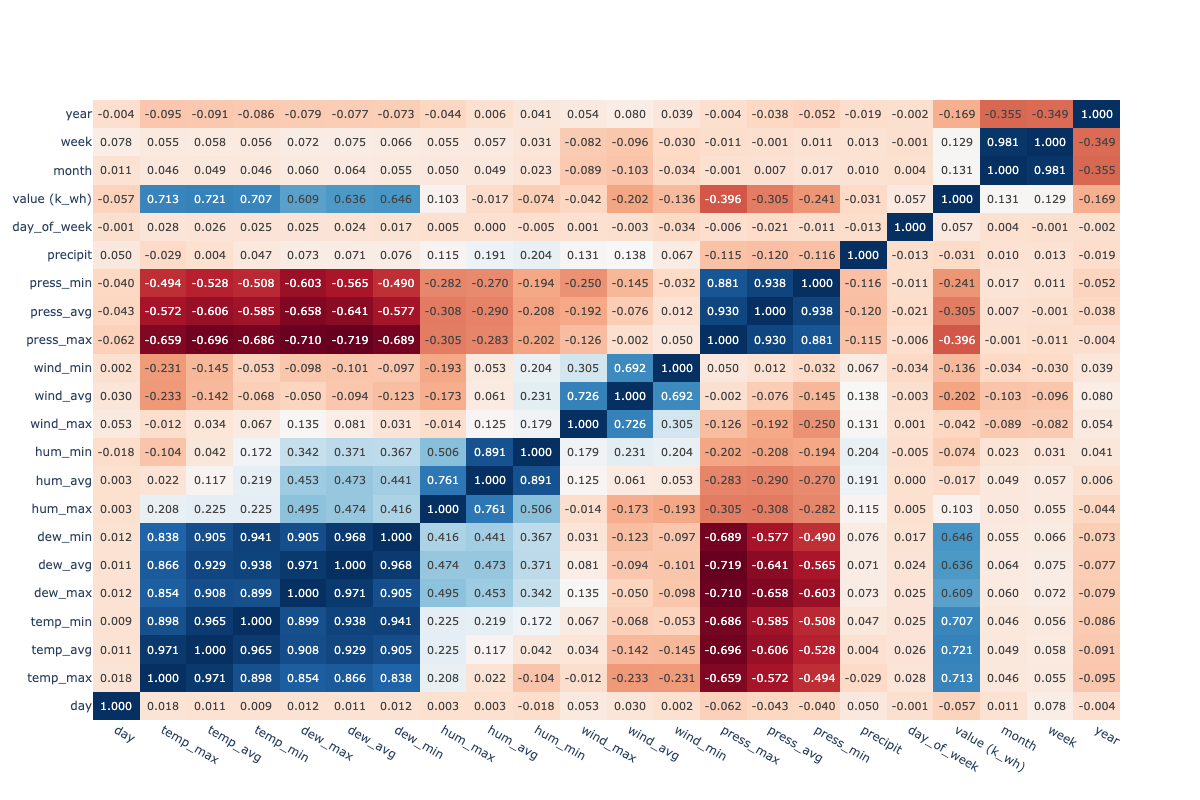

In [13]:
power_weather_corr = power_weather.corr(numeric_only=True)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Heatmap(x=power_weather_corr.columns, y=power_weather_corr.index, 
                         z=power_weather_corr, text=power_weather_corr, texttemplate="%{text:,.3f}",
                         colorscale="RdBu",
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"], len=0.5),
                         showscale=False
                         ),
            row=1, col=1)

fig.update_layout(height=800, width=1200)
fig.show(renderer="png")

The heatmap above shows the correlation between power consumption and weather data. As can be seen in the bottom left of the heatmap, the power consumption (value (k_wh)) are positively correlated to the temperatures. The correlation between power consumption and temperatures can be as high as 0.721 between power consumption and average temperature. Power consumption is negatively correlated to pressures, and this correlation can be as high as -0.396 between power consumption and max pressure recorded in a day.

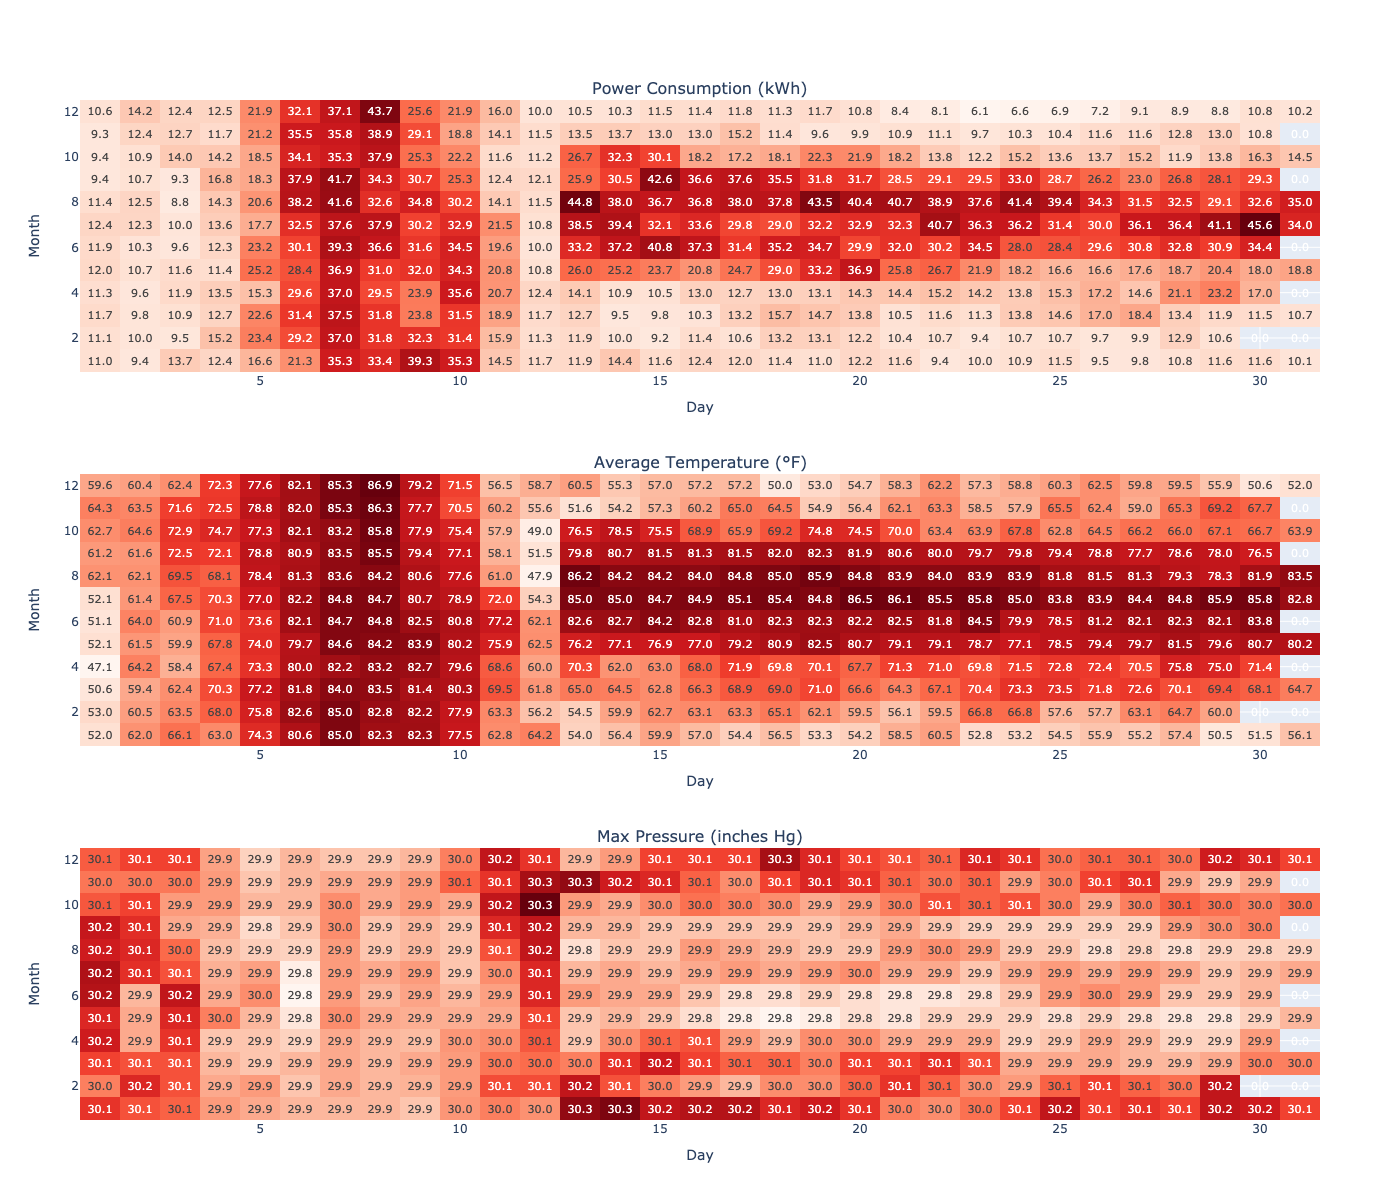

In [18]:
month_day = daily_power[["month", "power_day", "value (k_wh)"]].groupby(["month", "power_day"]).mean().unstack()

ave_temp = power_weather[["month", "day", "temp_avg"]].groupby(["month", "day"]).mean().unstack()
ave_temp.columns = [val for val in range(1,32)]

max_pressure = power_weather[["month", "day", "press_max"]].groupby(["month", "day"]).mean().unstack()
max_pressure.columns = [val for val in range(1,32)]
max_pressure


##### park this here. will come back later
# week_day = daily_power[["week", "day_name", "value (k_wh)"]].groupby(["week", "day_name"]).mean().unstack()
# week_day.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# week_day = week_day.T

fig_1a = make_subplots(rows=3, cols=1, vertical_spacing=0.1,
                       subplot_titles=["Power Consumption (kWh)", 
                                       "Average Temperature (\xb0F)", 
                                       "Max Pressure (inches Hg)"])

fig_1a.add_trace( go.Heatmap(x=[val[1] for val in month_day.columns], y=month_day.index,
                             z=month_day, text=month_day, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds"),
                             row=1, col=1)

fig_1a.add_trace( go.Heatmap(x=ave_temp.columns, y=ave_temp.index,
                             z=ave_temp, text=ave_temp, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds",),
                             row=2, col=1)

fig_1a.add_trace( go.Heatmap(x=max_pressure.columns, y=max_pressure.index,
                             z=max_pressure, text=max_pressure, texttemplate="%{text:.1f}", textfont={"size":11},
                             colorscale="reds",),
                             row=3, col=1)




fig_1a.update_xaxes(title_text="Day")
fig_1a.update_yaxes(title_text="Month")

fig_1a.update_traces(showscale=False)
fig_1a.update_layout(height=1200, width=1400)

fig_1a.show(renderer="png")

---
# Autocorrelation Plots

---

In [19]:
weather_dates = power_weather["weather_date"].to_list()

for ind, col in enumerate(power_weather_cols):

    acf_vals = acf(power_weather[col], nlags=400, missing="drop")

    if ind==0:
        df_cols = ["weather_date"]
        df_cols.append(col)
        pw_acf = pd.DataFrame(list(zip(weather_dates, acf_vals)), columns=df_cols)
    
    else:
        pw_acf[col] = acf_vals



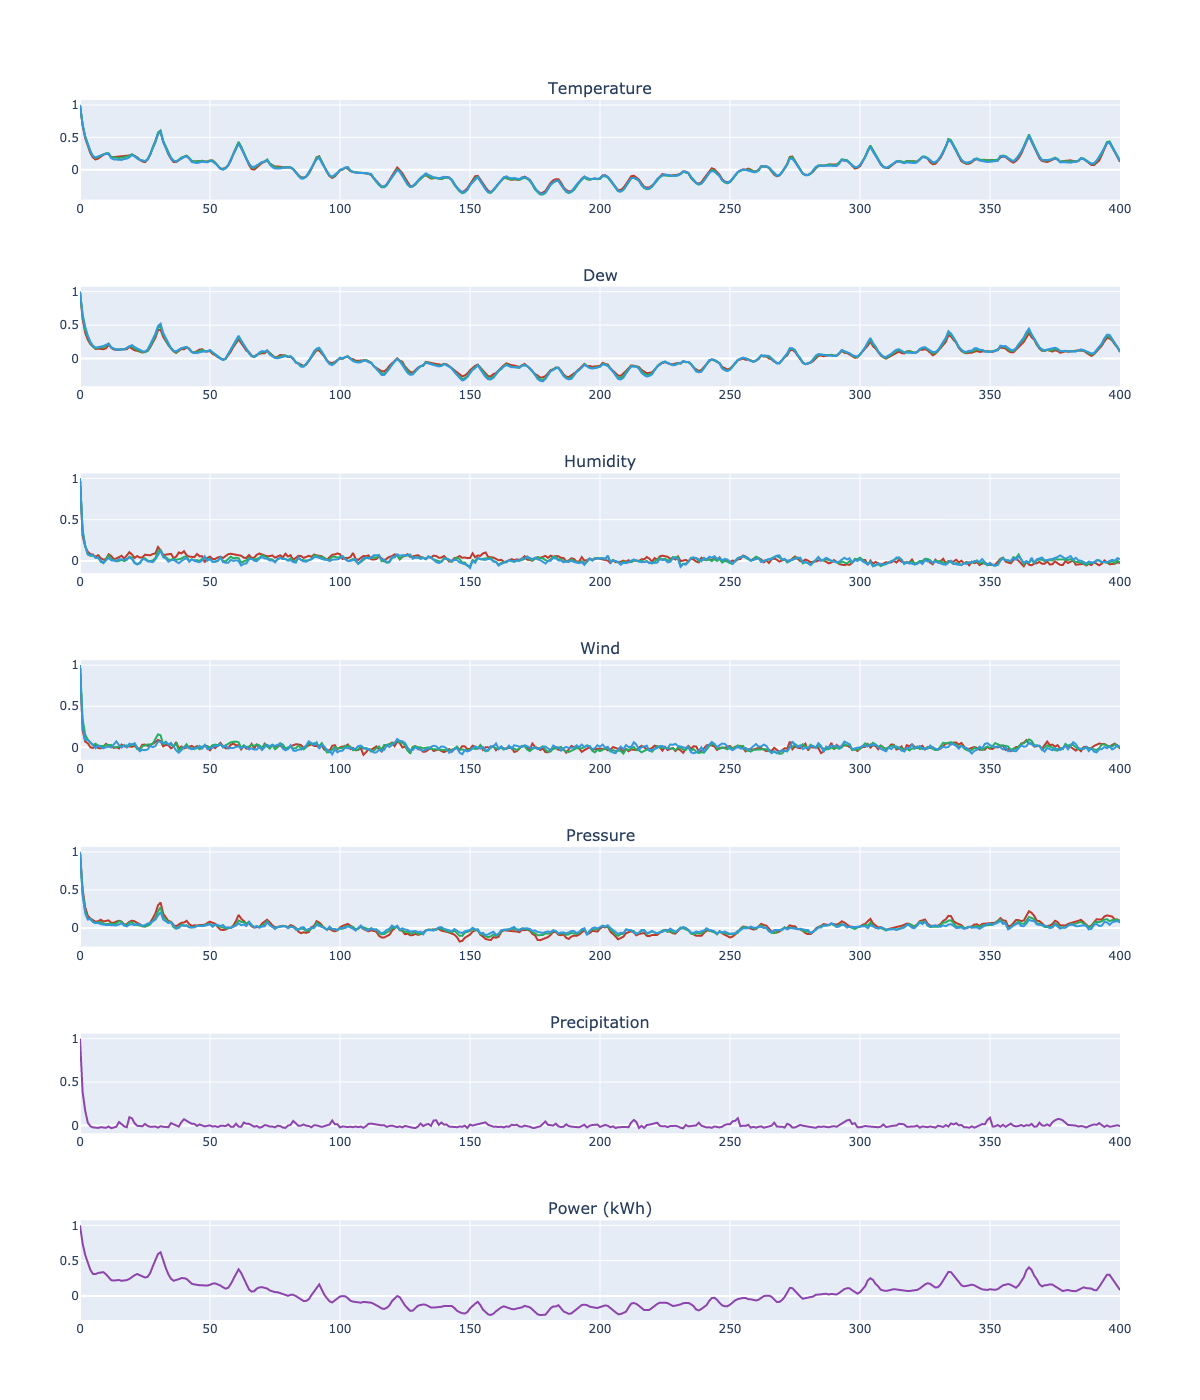

In [20]:
fig_2 = make_subplots(rows=7, cols=1, 
                      subplot_titles=["Temperature", "Dew", "Humidity", "Wind", "Pressure",
                                      "Precipitation", "Power (kWh)"])

ind = 0
col_n = ""

color_dict = {"min": "#3498DB", "avg": "#27AE60", "max": "#C0392B", "others": "#8E44AD"}


for ii in range(len(power_weather_cols)):

    col = power_weather_cols[ii]
    col_split = col.split("_")

    if (len(col_split)>1) and (col_split[1] in color_dict.keys()):
        color = color_dict[col_split[1]]
    else:
        color = color_dict["others"]


    if col_n != col_split[0]:
        col_n = col_split[0]
        ind = ind + 1

        fig_2.add_trace(
            go.Scatter(x=[val for val in range(len(pw_acf))], y=pw_acf[col], name=col,
                       line=dict(color=color)
                       ),
            row=ind,
            col=1
        )
    
    else:

        fig_2.add_trace(
            go.Scatter(x=[val for val in range(len(pw_acf))], y=pw_acf[col], name=col,
                       line=dict(color=color)
                       ),
            row=ind,
            col=1
        )


fig_2.update_layout(height=1400, width=1200, showlegend=False)
fig_2.show(renderer="png")

Humidity, Wind, Pressure, and Precipitation showed minimal autocorrelation, which tell us that the values of these variables are independent on itself. For instance, today's humidity is not dependent on yesterday's humidity value, or in another word the value for these variables occurred at random.

On the other hand, temperature, dew, and power (kWh) values have some dependent on previous values. For example, power consumption are correlated for lag at 31 days.

---
# <center> Power Consumption Forecast </center>

---


To make a forecast, the data was split into 2: training and testing set. The training set consists of data prior to 2020-01-01 and the testing set consists of data from 2020-01-01 onwards. 2 models were used to make the forecast: autoregressive and ARIMA. The accuracy of the forecasts using these models will be compared.

In [21]:
train_set = power_weather[power_weather["power_date"]<"2020-01-01"].copy()
test_set = power_weather[power_weather["power_date"]>="2020-01-01"].copy()

train_set

weather_date   day  temp_max   temp_avg   temp_min    dew_max  dew_avg  \
177    2016-07-01   1.0       NaN        NaN        NaN        NaN      NaN   
178    2016-07-02   2.0       NaN        NaN        NaN        NaN      NaN   
179    2016-07-03   3.0      88.0  79.600000  72.000000  72.000000     70.2   
180    2016-07-04   4.0      92.5  83.450000  76.500000  74.500000     72.7   
181    2016-07-05   5.0      95.0  85.133333  77.333333  75.333333     72.8   
...           ...   ...       ...        ...        ...        ...      ...   
1451   2019-12-27  27.0      69.0  62.400000  55.000000  62.000000     59.4   
1452   2019-12-28  28.0      77.0  69.600000  63.000000  68.000000     65.0   
1453   2019-12-29  29.0      69.0  60.800000  50.000000  66.000000     51.8   
1454   2019-12-30  30.0      61.0  50.300000  39.000000  37.000000     31.0   
1455   2019-12-31  31.0      60.0  48.800000  38.000000  39.000000     31.3   

      dew_min     hum_max  hum_avg  ...  press_avg  press_min  precipit  \
177       NaN         NaN      NaN  ...        NaN        NaN       NaN   
178       NaN         NaN      NaN  ...        NaN        NaN       NaN   
179      67.0  100.000000    75.20  ...  29.800000  29.700000      0.00   
180      69.5   94.000000    72.05  ...  29.850000  29.750000      0.00   
181      68.0   92.666667    69.10  ...  29.833333  29.733333      0.00   
...       ...         ...      ...  ...        ...        ...       ...   
1451     54.0   97.000000    90.00  ...  29.900000  29.800000      0.00   
1452     61.0   97.000000    85.90  ...  29.700000  29.600000      0.00   
1453     36.0   97.000000    75.60  ...  29.700000  29.600000      0.12   
1454     26.0   89.000000    51.80  ...  30.000000  29.900000      0.71   
1455     22.0   77.000000    55.30  ...  30.100000  30.000000      0.00   

      day_of_week  value (k_wh)  power_date  day_name  month  week  year  
177           NaN           NaN  2016-07-01    Friday      7    26  2016  
178           NaN           NaN  2016-07-02  Saturday      7    26  2016  
179           2.0     30.322000  2016-07-03    Sunday      7    26  2016  
180           2.5     36.077000  2016-07-04    Monday      7    27  2016  
181           3.0     44.511333  2016-07-05   Tuesday      7    27  2016  
...           ...           ...         ...       ...    ...   ...   ...  
1451          4.0      5.173000  2019-12-27    Friday     12    52  2019  
1452          5.0      5.200000  2019-12-28  Saturday     12    52  2019  
1453          6.0      5.309000  2019-12-29    Sunday     12    52  2019  
1454          0.0      4.947000  2019-12-30    Monday     12     1  2019  
1455          1.0      5.042000  2019-12-31   Tuesday     12     1  2019  

[1279 rows x 25 columns]

In [22]:
autoreg = AutoReg(train_set[["value (k_wh)", "power_date"]].set_index("power_date")
                  , lags=[val for val in range(1,71) if val%7], missing="drop"
                  , seasonal=True
                  , trend="t").fit()

autoreg_fitted = autoreg.predict(start="2016-07-03", end="2019-12-31")
autoreg_fitted = autoreg_fitted.to_frame().rename(columns={0:"fitted"})
autoreg_fitted["actual"] = train_set[["power_date", "value (k_wh)"]].set_index("power_date")
autoreg_fitted["residual"] = autoreg_fitted["fitted"] - autoreg_fitted["actual"]

autoreg_predict = autoreg.predict(start="2020-01-01", end="2020-06-30")
autoreg_predict = autoreg_predict.to_frame().rename(columns={0:"predicted"})
autoreg_predict["actual"] = test_set[["power_date", "value (k_wh)"]].set_index("power_date")
autoreg_predict["error"] = autoreg_predict["predicted"] - autoreg_predict["actual"]
autoreg_predict["squared_error"] = autoreg_predict["error"]**2
autoreg_predict["percent_error"] = autoreg_predict["error"]*100/autoreg_predict["actual"]
autoreg_stddev = stat.stdev(autoreg_predict["error"])
autoreg_predict["low_95"] = autoreg_predict["predicted"] - 1.96*autoreg_stddev
autoreg_predict["high_95"] = autoreg_predict["predicted"] + 1.96*autoreg_stddev

autoreg_fitted

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/deterministic.py:435: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.



fitted     actual  residual
2016-07-03        NaN  30.322000       NaN
2016-07-04        NaN  36.077000       NaN
2016-07-05        NaN  44.511333       NaN
2016-07-06        NaN  30.322000       NaN
2016-07-07        NaN  41.832000       NaN
...               ...        ...       ...
2019-12-27   8.818609   5.173000  3.645609
2019-12-28  10.783793   5.200000  5.583793
2019-12-29   9.972066   5.309000  4.663066
2019-12-30   7.580477   4.947000  2.633477
2019-12-31   7.816947   5.042000  2.774947

[1277 rows x 3 columns]

In [23]:
arima = ARIMA(train_set[["value (k_wh)", "power_date"]].set_index("power_date")
              , order=(30, 1, 1)
              , missing="drop").fit()

arima_fitted = arima.predict(start="2016-07-03", end="2019-12-31")
arima_fitted = arima_fitted.to_frame()#.rename(columns={0:"predicted"})
arima_fitted["actual"] = train_set[["power_date", "value (k_wh)"]].set_index("power_date")
arima_fitted["residual"] = arima_fitted["predicted_mean"] - arima_fitted["actual"]

arima_predict = arima.predict(start="2020-01-01", end="2020-06-30")
arima_predict = arima_predict.to_frame()#.rename(columns={0:"predicted"})
arima_predict["actual"] = test_set[["power_date", "value (k_wh)"]].set_index("power_date")
arima_predict["error"] = arima_predict["predicted_mean"] - arima_predict["actual"]
arima_predict["squared_error"] = arima_predict["error"]**2
arima_predict["percent_error"] = arima_predict["error"]*100/arima_predict["actual"]
arima_stddev = stat.stdev(arima_predict["error"])
arima_predict["low_95"] = arima_predict["predicted_mean"] - 1.96*arima_stddev
arima_predict["high_95"] = arima_predict["predicted_mean"] + 1.96*arima_stddev


arima_fitted

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted_mean     actual   residual
2016-07-03        0.000000  30.322000 -30.322000
2016-07-04       30.321144  36.077000  -5.755856
2016-07-05       35.046996  44.511333  -9.464338
2016-07-06       42.008130  30.322000  11.686130
2016-07-07       31.499036  41.832000 -10.332964
...                    ...        ...        ...
2019-12-27        8.410602   5.173000   3.237602
2019-12-28        9.782582   5.200000   4.582582
2019-12-29        9.198604   5.309000   3.889604
2019-12-30        8.281821   4.947000   3.334821
2019-12-31        6.491166   5.042000   1.449166

[1277 rows x 3 columns]

---
# Residual Diagnostic on Training Set

---

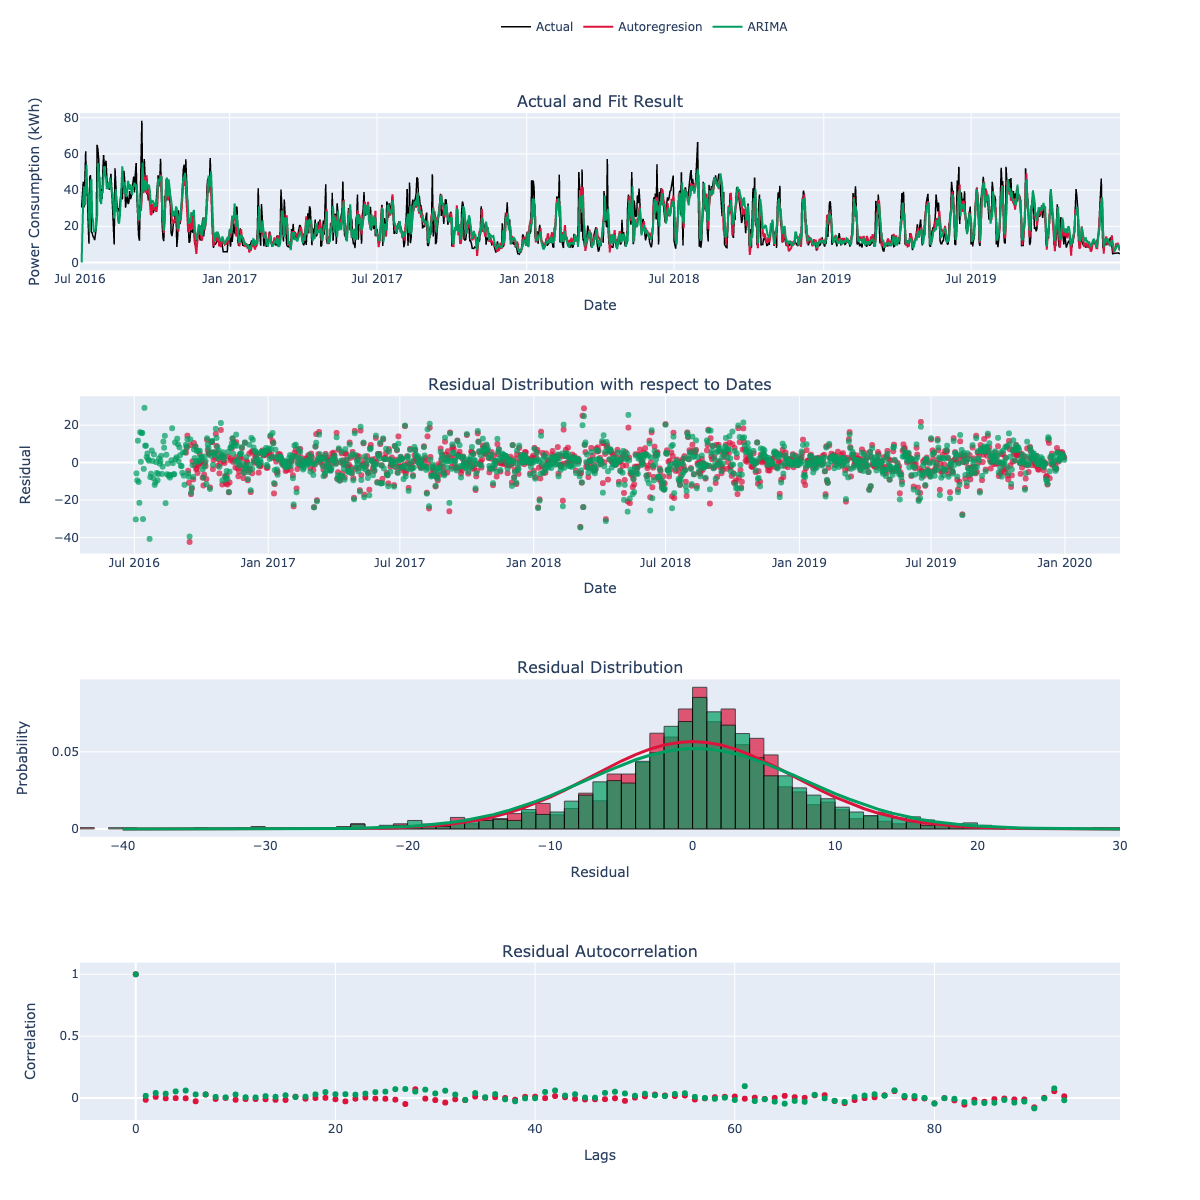

In [24]:
fig = make_subplots(rows=4, cols=1,
                    subplot_titles=["Actual and Fit Result", "Residual Distribution with respect to Dates",
                                    "Residual Distribution", "Residual Autocorrelation"])

diff_models = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                          , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_fitted.index, y=autoreg_fitted["fitted"], line=dict(color="#DC143C")
                             , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_fitted.index, y=arima_fitted["predicted_mean"], line=dict(color="#009E60")
                             , showlegend=True, legendgroup="ARIMA", name="ARIMA")
                ]

residual_dist = [go.Scatter(x=autoreg_fitted.index, y=autoreg_fitted["residual"], mode="markers", marker=dict(color="#DC143C", opacity=0.7)
                    , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_fitted.index, y=arima_fitted["residual"], mode="markers", marker=dict(color="#009E60", opacity=0.7)
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 ]

residual_dist_2 = [ go.Histogram(x=autoreg_fitted["residual"], histnorm="probability"
                                 , marker=dict(color="#DC143C", line_width=1, line_color="black", opacity=0.7)
                                , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                    , go.Histogram(x=arima_fitted["residual"], histnorm="probability"
                                , marker=dict(color="#009E60", line_width=1, line_color="black", opacity=0.7)
                                , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                    ]

autoreg_fitted_acf = acf(autoreg_fitted["residual"].dropna(), nlags=93)
arima_fitted_acf = acf(arima_fitted["residual"], nlags=93)
lags = [val for val in range(len(arima_fitted_acf))]

acf_traces = [ go.Scatter(x=lags, y=autoreg_fitted_acf
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=lags, y=arima_fitted_acf
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]


autoreg_dist = norm(stat.mean(autoreg_fitted["residual"].dropna().values), stat.stdev(autoreg_fitted["residual"].dropna().values))
arima_dist = norm(stat.mean(arima_fitted["residual"]), stat.stdev(arima_fitted["residual"]))

dist_vals = [val for val in range(-40, 31)]
autoreg_probs = [autoreg_dist.pdf(value) for value in dist_vals]
arima_probs = [arima_dist.pdf(value) for value in dist_vals]

fitted_dist = [go.Scatter(x=dist_vals, y=autoreg_probs
                             , mode="lines", line=dict(color="#DC143C", width=3)
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=dist_vals, y=arima_probs
                             , mode="lines", line=dict(color="#009E60", width=3)
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]


for model in diff_models:
    fig.add_trace(model, row=1, col=1)

for dist in residual_dist:
    fig.add_trace(dist, row=2, col=1)

for dist_2 in residual_dist_2:
    fig.add_trace(dist_2, row=3, col=1)

for dist_3 in fitted_dist:
    fig.add_trace(dist_3, row=3, col=1)

for acf_val in acf_traces:
    fig.add_trace(acf_val, row=4, col=1)

xaxes = ["Date", "Date", "Residual", "Lags"]
yaxes = ["Power Consumption (kWh)", "Residual", "Probability", "Correlation"]

for num, xlabel in enumerate(xaxes):
    fig.update_xaxes(title_text=xlabel, row=num+1)

for num, ylabel in enumerate(yaxes):
    fig.update_yaxes(title_text=ylabel, row=num+1)


fig.update_layout(height=1200, width=1200, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.4, orientation="h"), barmode="overlay")

fig.show(renderer="png")

The top most plot shows how the actual power consumption data and fitted data using autoregressive and ARIMA model. The fitted data fits nicely to the actual data. 

The second plot from the top shows the residual distribution of the model with respect to dates. Overall, the residuals centered around zero and no pattern can be observed from this distribution.

The third plot shows the residual plot probability distribution. The solid red and green lines are the fitted normal pdf for autoregressive model and arima model, respectively. In both cases, the residuals were normally distributed.

The final plot shows the residual autocorrelation for both models. This plot shows that the correlation drops to almost zero starting from lag = 1 indicating that the residuals are random for both models.



---
# Forecast Plots

---

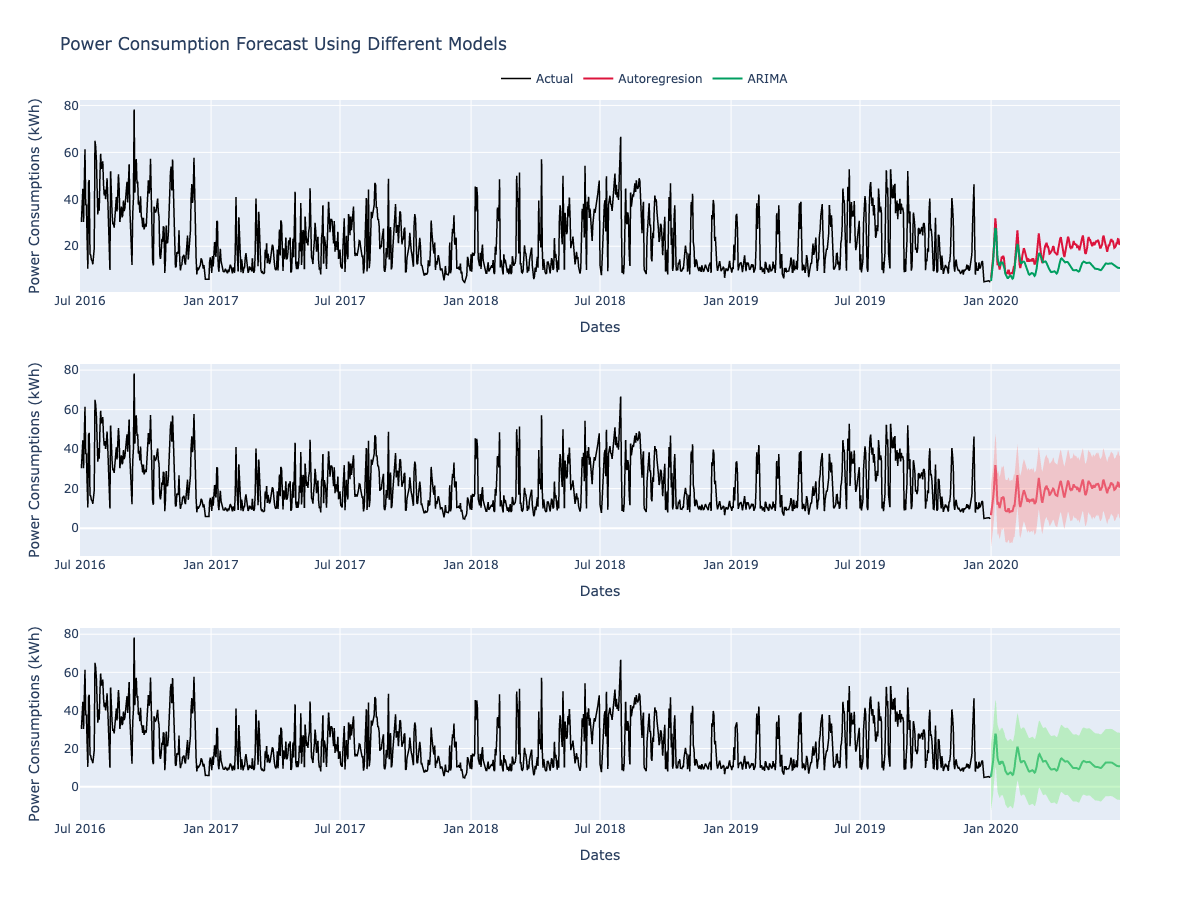

In [25]:
fig = make_subplots(rows=3, cols=1)

diff_models = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                          , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                             , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                             , showlegend=True, legendgroup="ARIMA", name="ARIMA")
                ]

autoreg_traces = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                             , showlegend=False, legendgroup="Actual", name="Actual")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["high_95"], line=dict(color="#FAA0A0", width=0)
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["low_95"], line=dict(color="#FAA0A0", width=0), fill="tonexty"
                              , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                 ]

arima_traces = [go.Scatter(x=train_set["power_date"], y=train_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=False, legendgroup="Actual", name="Actual")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["high_95"], line=dict(color="#90EE90", width=0)
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 , go.Scatter(x=arima_predict.index, y=arima_predict["low_95"], line=dict(color="#90EE90", width=0), fill="tonexty"
                              , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                 ]

for model in diff_models:
    fig.add_trace(model, row=1, col=1)

for autoreg_trace in autoreg_traces:
    fig.add_trace(autoreg_trace, row=2, col=1)

for arima_trace in arima_traces:
    fig.add_trace(arima_trace, row=3, col=1)

fig.update_xaxes(title_text="Dates")
fig.update_yaxes(title_text="Power Consumptions (kWh)")
fig.update_layout(height=900, width=1200, legend=dict(yanchor="top", y=1.05, xanchor="left", x=0.4, orientation="h"),
                  title='Power Consumption Forecast Using Different Models')


fig.show(renderer="png")

The above plots shows the forecasted values from 2020-01-01. The first plot shows the forecast generated by different models: autoregressive (red) and ARIMA (green). The second and third plot show each plot with its prediction interval at 95% intervals.

The table below shows the accuracy as measured by 3 different metrics: mean absolute error (mae), root mean square error (rmse), and mean absolute percentage error (mape). Autoregressive model performs better 2/3 of the time relative to arima model.

In [26]:
autoreg_mae = stat.mean(abs(autoreg_predict["error"]))
autoreg_mse = stat.sqrt(stat.mean(autoreg_predict["squared_error"]))
autoreg_mape = stat.mean(abs(autoreg_predict["percent_error"]))

arima_mae = stat.mean(abs(arima_predict["error"]))
arima_mse = stat.sqrt(stat.mean(arima_predict["squared_error"]))
arima_mape = stat.mean(abs(arima_predict["percent_error"]))

summary_ind = ["autoregressive", "arima"]
summary_col = ["mae", "rmse", "mape"]

maes = [autoreg_mae, arima_mae]
mses = [autoreg_mse, arima_mse]
mapes = [autoreg_mape, arima_mape]

mdl_acc = pd.DataFrame(list(zip(maes, mses, mapes)), index=summary_ind, columns=summary_col)

mdl_acc

mae       rmse       mape
autoregressive  6.561896   8.084728  39.019322
arima           8.477119  11.561713  36.780657

---
# Residual Diagnostic for Testing Set

---
The residual diagnostic for testing set and improving the forecasting ability will be left for future work.

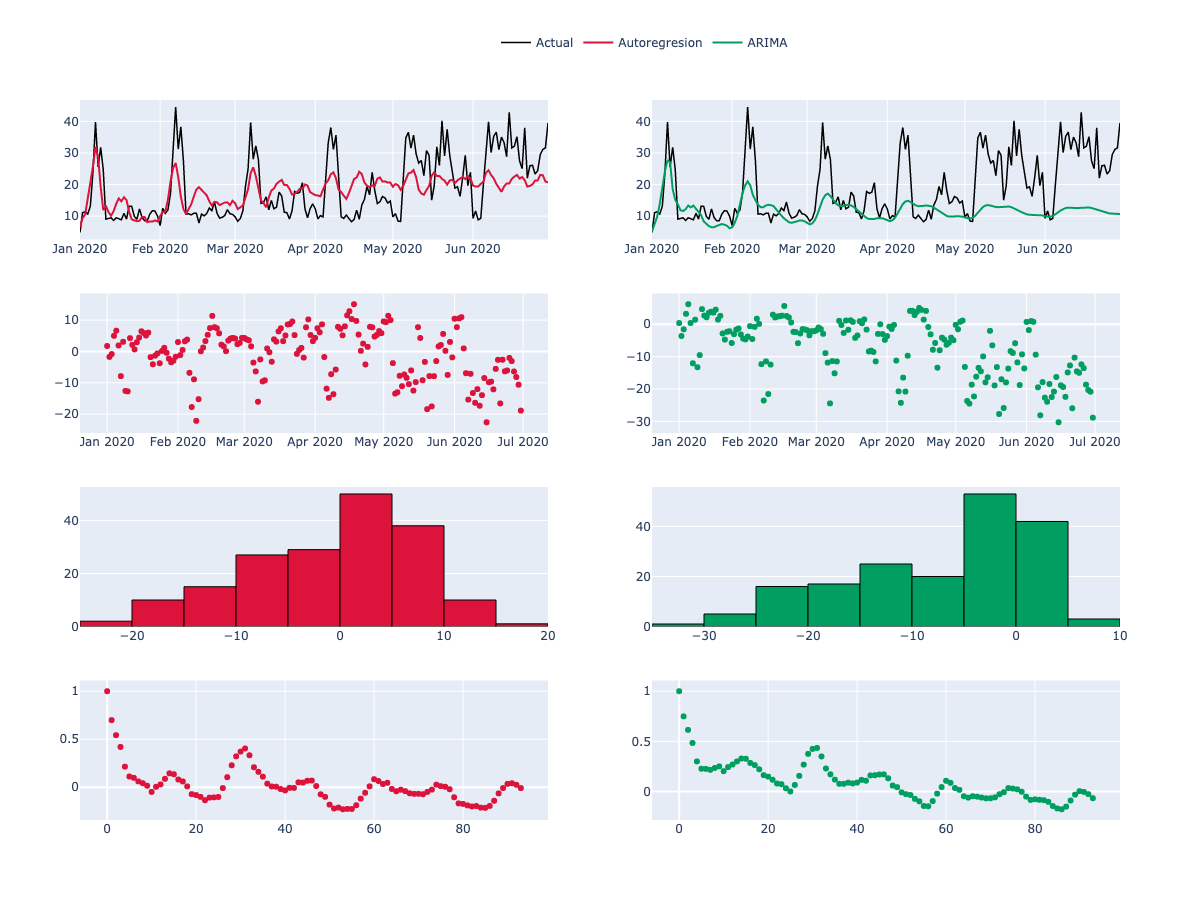

In [27]:
fig = make_subplots(rows=4, cols=2)

autoreg_acf = acf(autoreg_predict["error"], nlags=93)
arima_acf = acf(arima_predict["error"], nlags=93)
lags = [val for val in range(len(arima_acf))]


plot_trace = [ go.Scatter(x=test_set["power_date"], y=test_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=True, legendgroup="Actual", name="Actual")
                , go.Scatter(x=test_set["power_date"], y=test_set["value (k_wh)"], line=dict(color="black", width=1.5)
                           , showlegend=False, legendgroup="Actual", name="Actual")
                , go.Scatter(x=autoreg_predict.index, y=autoreg_predict["predicted"], line=dict(color="#DC143C")
                              , showlegend=True, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["predicted_mean"], line=dict(color="#009E60")
                              , showlegend=True, legendgroup="ARIMA", name="ARIMA")]

residual_dist = [ go.Scatter(x=autoreg_predict.index, y=autoreg_predict["error"]
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=arima_predict.index, y=arima_predict["error"]
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]

residual_dist_2 = [ go.Histogram(x=autoreg_predict["error"], marker=dict(color="#DC143C", line_width=1, line_color="black")
                                , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                    , go.Histogram(x=arima_predict["error"], marker=dict(color="#009E60", line_width=1, line_color="black")
                                , showlegend=False, legendgroup="ARIMA", name="ARIMA")
                    ]

acf_traces = [ go.Scatter(x=lags, y=autoreg_acf
                             , mode="markers", marker=dict(color="#DC143C")
                             , showlegend=False, legendgroup="Autoregression", name="Autoregresion")
                , go.Scatter(x=lags, y=arima_acf
                             , mode="markers", marker=dict(color="#009E60")
                             , showlegend=False, legendgroup="ARIMA", name="ARIMA")]

for num, md in enumerate(plot_trace):
    fig.add_trace(md, row=1, col=num%2+1)

for num, md in enumerate(residual_dist):
    fig.add_trace(md, row=2, col=num%2+1)

for num, md in enumerate(residual_dist_2):
    fig.add_trace(md, row=3, col=num%2+1)

for num, md in enumerate(acf_traces):
    fig.add_trace(md, row=4, col=num%2+1)


fig.update_layout(height=900, width=1200, legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.4, orientation="h"))

fig.show(renderer="png")

----

### Forecasting Using TensorFlow

---

In [5]:
import IPython
import IPython.display
import tensorflow as tf

from numpy.random import normal
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA




In [74]:
def arima_nan_filler(data, col_name):

    ##### get index of rows with nan
    nan_index = power_df[power_df[col_name].isna()].index

    ##### get difference in nan rows
    nan_index_diff = np.diff(nan_index)

    ##### get index of nan_index where nan_index > 1
    nan_index_2 = [ii for ii, val in enumerate(nan_index_diff) if val>1]

    ##### index of rows where the nan values are not consecutive
    nan_index_3 = [val for jj, val in enumerate(nan_index) if jj in nan_index_2]
    nan_index_3.append(max(nan_index))


    # print(f"nan_index_2 length {len(nan_index_2)}")
    # print(f"nan_index_3 length {len(nan_index_3)}")

    new_df = data[["start_date", col_name]].dropna()

    for num, val in enumerate(nan_index_3):

        ##### split the input data based on nan values

        if num==0:

            ##### split the input data 
            split_df = data.loc[num:val, ["start_date", col_name]]
            
            # ##### get min index where value is nan
            # min_nan_index = min(split_df[split_df[col_name].isna()].index)
            # max_nan_index = max(split_df[split_df[col_name].isna()].index)

            # model = ARIMA(split_df.loc[:min_nan_index, ["start_date", col_name]].set_index("start_date").asfreq(freq="h"),
            #           order=(30,1,1) ).fit()
            
            # predict = model.predict(start=split_df.loc[min_nan_index, "start_date"],
            #                         end=split_df.loc[max_nan_index, "start_date"])\
            #                 .to_frame()\
            #                 .reset_index(drop=False)\
            #                 .rename(columns={"predicted_mean": col_name, "index":"start_date"})
            
            # split_dict[num] = pd.concat([split_df.dropna(), predict])
        
        else:
            ##### split the input data 
            split_df = data.loc[nan_index_3[num-1]+1:val, ["start_date", col_name]]
            
        ##### get min index where value is nan
        min_nan_index = min(split_df[split_df[col_name].isna()].index)
        max_nan_index = max(split_df[split_df[col_name].isna()].index)

        # print(f"This is split {num}")
        # print(split_df)

        model = ARIMA(split_df.loc[:min_nan_index, ["start_date", col_name]].set_index("start_date").asfreq(freq="h"),
                    order=(30,1,1) ).fit()
        
        predict = model.predict(start=split_df.loc[min_nan_index, "start_date"],
                                end=split_df.loc[max_nan_index, "start_date"])\
                        .to_frame()\
                        .reset_index(drop=False)\
                        .rename(columns={"predicted_mean": col_name, "index":"start_date"})
        
        new_df = pd.concat([new_df, predict])
        

    new_df = new_df.sort_values("start_date").reset_index(drop=True).rename(columns={"start_date": "start_date_2"})
    
    data = data.drop(columns=col_name)
    data = data.merge(new_df, left_on="start_date", right_on="start_date_2", how="left").drop(columns="start_date_2")
        
    # #### temporary for debug
    # data=0
    # new_df=0

    return data, new_df

In [8]:
power_df = pd.read_csv("power_usage_2016_to_2020.csv")
power_df.columns = [underscore(val) for val in power_df.columns]

power_df["start_date"] = pd.to_datetime(power_df["start_date"])
power_df["power_date"] = power_df["start_date"].dt.date

power_df = power_df.sort_values("start_date").set_index("start_date").asfreq(freq="1h")
power_df = power_df.reset_index()

power_df.head(5)



start_date  value (k_wh)  day_of_week    notes  power_date
0 2016-01-06 00:00:00         1.057          2.0  weekday  2016-01-06
1 2016-01-06 01:00:00         1.171          2.0  weekday  2016-01-06
2 2016-01-06 02:00:00         0.560          2.0  weekday  2016-01-06
3 2016-01-06 03:00:00         0.828          2.0  weekday  2016-01-06
4 2016-01-06 04:00:00         0.932          2.0  weekday  2016-01-06

### Notes:
* A lot of missing data for dates before 6 June 2016 and after 5 July 2020
    - Treatment: Clip data. Remove data prior to 6 June 2016 and post 5 July 2020
* Some missing data between 6 June 2016 and 5 July 2020
    - Average: use moving average for missing data
    - Pad: use data from previous values
    - Pad with random: use data from previous values plus some random values

In [31]:
##### Data treatments

##### Clip data
power_df = power_df.loc[(power_df["start_date"]>="2016-06-06") & (power_df["start_date"]<="2020-07-05"), ["start_date", "value (k_wh)"]].reset_index(drop=True)

##### Make copies of data and fill missing data using different approach

##### use average of the past 7 days
power_df["fill_ave"] = power_df["value (k_wh)"].copy(deep=True)
power_df["fill_ave"] = power_df["fill_ave"].fillna(power_df["fill_ave"].rolling(168, min_periods=1, center=False).mean(numeric_only=True))

##### use last observed values
power_df["fill_pad"] = power_df["value (k_wh)"].copy(deep=True)
power_df["fill_pad"] = power_df["fill_pad"].fillna(method="ffill")

##### use last observed values with random values
power_df["fill_arima"] = power_df["value (k_wh)"].copy(deep=True)

# nan_index = power_df[power_df["value (k_wh)"].isna()].index
# # non_nan_std_dev = stat.stdev(power_df.loc[~power_df["value (k_wh)"].isna(), "value (k_wh)"])/3
# # norm_rand = normal(loc=0, scale=non_nan_std_dev, size=len(nan_index))
# norm_rand = [np.sin(val*np.pi) for val in np.linspace(0,15,len(nan_index))]

# power_df["fill_sin"] = power_df["fill_sin"].fillna(method="ffill")
# power_df.loc[nan_index, "fill_sin"] = abs(power_df.loc[nan_index, "fill_sin"] + norm_rand)



power_df

start_date  value (k_wh)  fill_ave  fill_pad  fill_arima
0     2016-06-06 00:00:00         0.885     0.885     0.885       0.885
1     2016-06-06 01:00:00         0.739     0.739     0.739       0.739
2     2016-06-06 02:00:00         0.987     0.987     0.987       0.987
3     2016-06-06 03:00:00         0.650     0.650     0.650       0.650
4     2016-06-06 04:00:00         0.757     0.757     0.757       0.757
...                   ...           ...       ...       ...         ...
35756 2020-07-04 20:00:00         3.014     3.014     3.014       3.014
35757 2020-07-04 21:00:00         1.088     1.088     1.088       1.088
35758 2020-07-04 22:00:00         0.875     0.875     0.875       0.875
35759 2020-07-04 23:00:00         1.142     1.142     1.142       1.142
35760 2020-07-05 00:00:00         0.863     0.863     0.863       0.863

[35761 rows x 5 columns]

In [75]:
# temp = np.diff(nan_index)

# index_2 = [ii for ii, val in enumerate(temp) if val>1] #### index of temp

# index_2

# index_3 = [val for jj, val in enumerate(nan_index) if jj in index_2] #### index of rows with more than 1 hour different

temp = arima_nan_filler(power_df, "fill_arima")
temp


# power_df[power_df["fill_arima"].isna()]


/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting aut

(               start_date  value (k_wh)  fill_ave  fill_pad  fill_arima
 0     2016-06-06 00:00:00         0.885     0.885     0.885       0.885
 1     2016-06-06 01:00:00         0.739     0.739     0.739       0.739
 2     2016-06-06 02:00:00         0.987     0.987     0.987       0.987
 3     2016-06-06 03:00:00         0.650     0.650     0.650       0.650
 4     2016-06-06 04:00:00         0.757     0.757     0.757       0.757
 ...                   ...           ...       ...       ...         ...
 35756 2020-07-04 20:00:00         3.014     3.014     3.014       3.014
 35757 2020-07-04 21:00:00         1.088     1.088     1.088       1.088
 35758 2020-07-04 22:00:00         0.875     0.875     0.875       0.875
 35759 2020-07-04 23:00:00         1.142     1.142     1.142       1.142
 35760 2020-07-05 00:00:00         0.863     0.863     0.863       0.863
 
 [35761 rows x 5 columns],
              start_date_2  fill_arima
 0     2016-06-06 00:00:00       0.885
 1     2016-06-06

In [76]:
# power_df[power_df["value (k_wh)"].isna()]
# len(power_df)
# temp.groupby("start_date").count()
# temp1[temp1["value (k_wh)"].isna()]
temp1, temp2 = temp

len(temp1)

# # temp1[temp1["fill_arima"]]
# temp3 = power_df.merge(temp2, left_on="start_date", right_on="start_date_2", how="left")
# temp3[temp3["fill_arima_y"].isna()]
# temp2

35761

In [77]:
# power_df.groupby("start_date").count().sort_values("fill_arima")
# temp1.groupby("start_date").count()
# len(power_df[power_df["value (k_wh)"].isna()])
power_df
# power_df[(power_df["start_date"]>="2020-06-07 00:00:00") & (power_df["start_date"]<"2020-06-13 00:00:00")]
# temp

start_date  value (k_wh)  fill_ave  fill_pad  fill_arima
0     2016-06-06 00:00:00         0.885     0.885     0.885       0.885
1     2016-06-06 01:00:00         0.739     0.739     0.739       0.739
2     2016-06-06 02:00:00         0.987     0.987     0.987       0.987
3     2016-06-06 03:00:00         0.650     0.650     0.650       0.650
4     2016-06-06 04:00:00         0.757     0.757     0.757       0.757
...                   ...           ...       ...       ...         ...
35756 2020-07-04 20:00:00         3.014     3.014     3.014       3.014
35757 2020-07-04 21:00:00         1.088     1.088     1.088       1.088
35758 2020-07-04 22:00:00         0.875     0.875     0.875       0.875
35759 2020-07-04 23:00:00         1.142     1.142     1.142       1.142
35760 2020-07-05 00:00:00         0.863     0.863     0.863       0.863

[35761 rows x 5 columns]

In [314]:
from statsmodels.tsa.arima.model import ARIMA

forecast_temp = ARIMA(sub_temp.loc[:600, ["start_date", "value (k_wh)"]].set_index("start_date").asfreq(freq="h"),
                      order=(30,1,1) ).fit()



/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/jazli2023/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [322]:
forecast_temp.predict(start="2016-07-01 00:00:00", end="2016-07-05 23:00:00").to_frame().

predicted_mean
2016-07-01 00:00:00        1.309091
2016-07-01 01:00:00        0.946729
2016-07-01 02:00:00        1.054053
2016-07-01 03:00:00        0.944379
2016-07-01 04:00:00        0.723991
...                             ...
2016-07-05 19:00:00        2.918123
2016-07-05 20:00:00        2.795193
2016-07-05 21:00:00        2.557417
2016-07-05 22:00:00        2.250916
2016-07-05 23:00:00        1.916883

[120 rows x 1 columns]

In [315]:
fig = go.Figure( go.Scatter(x=sub_temp[600:].index, y=forecast_temp.predict(start="2016-07-01 00:00:00", end="2016-07-05 23:00:00"), mode="markers"))

fig.add_trace( go.Scatter(x=sub_temp[0:600].index, y=sub_temp.loc[0:600, "value (k_wh)"]))

fig.show()

In [175]:
fig = go.Figure( go.Scatter(x=power_df["start_date"], y=power_df["value (k_wh)"], marker=dict(color="black")))

fig.add_trace( go.Scatter(x=power_df.loc[nan_index, "start_date"], y=power_df.loc[nan_index, "fill_ave"], mode="markers", marker=dict(color="#DC143C")) )
fig.add_trace( go.Scatter(x=power_df.loc[nan_index, "start_date"], y=power_df.loc[nan_index, "fill_pad"], mode="markers", marker=dict(color="#008000")) )
fig.add_trace( go.Scatter(x=power_df.loc[nan_index, "start_date"], y=power_df.loc[nan_index, "fill_sin"], mode="markers", marker=dict(color="#6495ED")) )


fig.show()

### Methodology

* split the data as follows:
    - training set: 70%
    - validation set: 20%
    - testing set: 10%

* for each set, there are 4 data treatments:
    - no treatments
    - average
    - pad
    - pad + sinusoidal wave

* 2 models will be utilize:
    - single-shot model
    - autoregressive model


* in total, there will be 8 models:

| | no_treatment | fill_ave | fill_pad | fill_sin|
| --- | --- | --- | --- | --- |
| single-shot model | ssm_no | ssm_ave | ssm_pad | ssm_sin |
| autoregressive model | auto_no | auto_ave | auto_pad | auto_sin |




In [178]:
power_df.head(3)

start_date  value (k_wh)  fill_ave  fill_pad  fill_sin
0 2016-06-06 00:00:00         0.885     0.885     0.885     0.885
1 2016-06-06 01:00:00         0.739     0.739     0.739     0.739
2 2016-06-06 02:00:00         0.987     0.987     0.987     0.987

In [213]:
column_indices = {name: i for i, name in enumerate(power_df.columns)}

first_split = int(len(power_df)*0.7)
second_split = int(len(power_df)*0.9)

#### No data treatment group
train_no = power_df.loc[0:first_split, ["value (k_wh)"]].dropna()
val_no = power_df.loc[first_split:second_split, ["value (k_wh)"]].dropna()
test_no = power_df.loc[second_split:, ["value (k_wh)"]].dropna()

#### Average-fill data treatment group
train_ave = power_df.loc[0:first_split, ["fill_ave"]]
val_ave = power_df.loc[first_split:second_split, ["fill_ave"]]
test_ave = power_df.loc[second_split:, ["fill_ave"]]

#### Forward fill data treatment group
train_pad = power_df.loc[0:first_split, ["fill_pad"]]
val_pad = power_df.loc[first_split:second_split, ["fill_pad"]]
test_pad = power_df.loc[second_split:, ["fill_pad"]]

#### Forward fill with sinusoidal wave data treatment group
train_sin = power_df.loc[0:first_split, ["fill_sin"]]
val_sin = power_df.loc[first_split:second_split, ["fill_sin"]]
test_sin = power_df.loc[second_split:, ["fill_sin"]]



num_features = power_df["value (k_wh)"].to_frame().shape[1]

train_ave

fill_ave
0         0.885
1         0.739
2         0.987
3         0.650
4         0.757
...         ...
25028     0.399
25029     0.830
25030     0.860
25031     0.416
25032     0.313

[25033 rows x 1 columns]

In [238]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window
  
def plot(self, model=None, max_subplots=3): #plot_col='value (k_wh)', 
  inputs, labels = self.example
  plot_col = self.train_df.columns[0]
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [239]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [240]:
OUT_STEPS = 24

no_treatment_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                                        train_df=train_no, val_df=val_no, test_df=test_no, label_columns=["value (k_wh)"])

fill_ave_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                                        train_df=train_ave, val_df=val_ave, test_df=test_ave, label_columns=["fill_ave"])

fill_pad_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                                        train_df=train_pad, val_df=val_pad, test_df=test_pad, label_columns=["fill_pad"])

fill_sin_window = WindowGenerator(input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS,
                                        train_df=train_sin, val_df=val_sin, test_df=test_sin, label_columns=["fill_sin"])

fill_ave_window



Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['fill_ave']

In [54]:
# # Stack three slices, the length of the total window.
# example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
#                            np.array(train_df[100:100+multi_window.total_window_size]),
#                            np.array(train_df[200:200+multi_window.total_window_size])])

# example_inputs, example_labels = multi_window.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 1)
Inputs shape: (3, 24, 1)
Labels shape: (3, 24, 1)


In [ ]:
# multi_window.example = example_inputs, example_labels

# multi_window.plot()

219/219 [==============================] - 0s 537us/step - loss: 0.9205 - mean_absolute_error: 0.6049


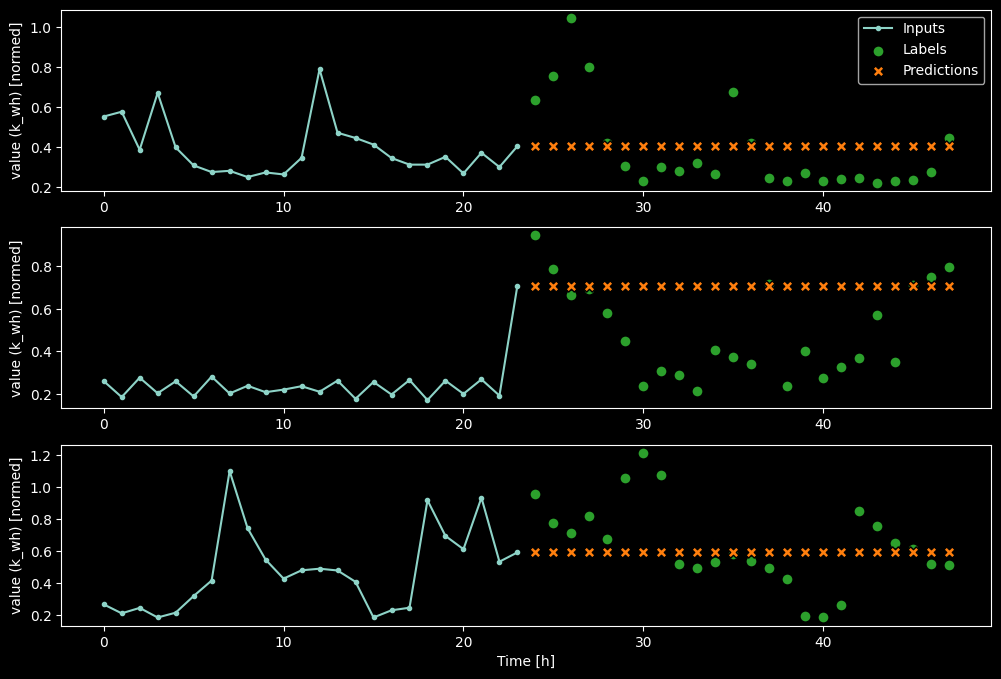

In [218]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(no_treatment_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(no_treatment_window.test, verbose=0, return_dict=True)
no_treatment_window.plot(last_baseline)

In [219]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# multi_lstm_model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units].
#     # Adding more `lstm_units` just overfits more quickly.
#     tf.keras.layers.LSTM(32, return_sequences=False),
#     # Shape => [batch, out_steps*features].
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                           kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features].
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

219/219 [==============================] - 0s 913us/step - loss: 0.3792 - mean_absolute_error: 0.3828


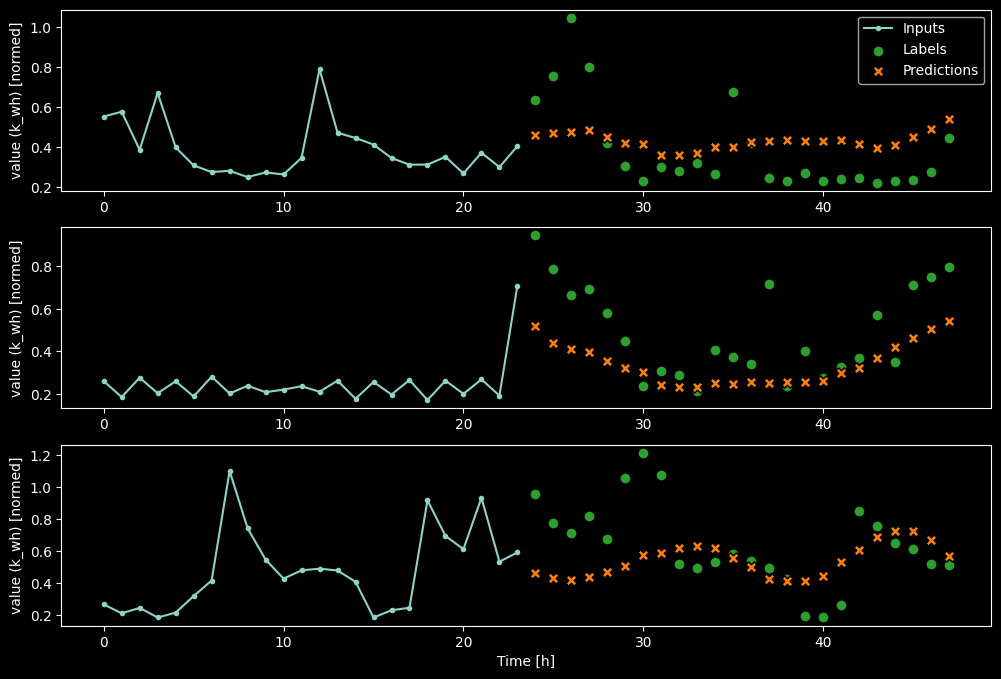

In [220]:
no_treatment_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(no_treatment_model, no_treatment_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = no_treatment_model.evaluate(no_treatment_window.val, return_dict=True)
multi_performance['LSTM'] = no_treatment_model.evaluate(no_treatment_window.test, verbose=0, return_dict=True)
no_treatment_window.plot(no_treatment_model)

223/223 [==============================] - 0s 928us/step - loss: 0.3825 - mean_absolute_error: 0.4046


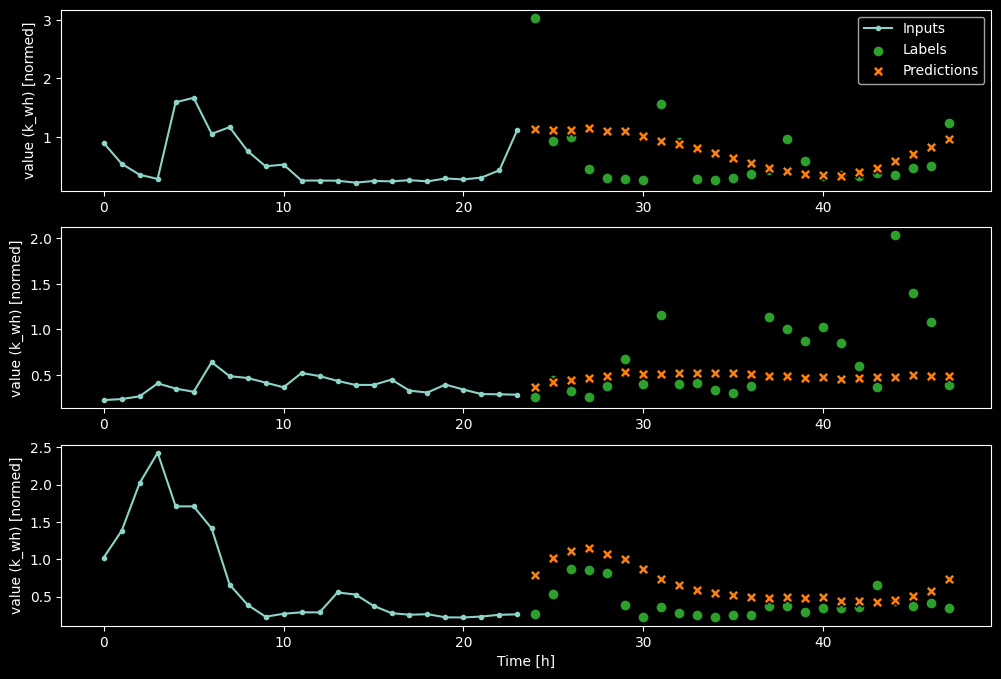

In [241]:
fill_ave_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

fill_ave_history = compile_and_fit(fill_ave_model, fill_ave_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = fill_ave_model.evaluate(fill_ave_window.val, return_dict=True)
multi_performance['LSTM'] = fill_ave_model.evaluate(fill_ave_window.test, verbose=0, return_dict=True)
no_treatment_window.plot(fill_ave_model)

223/223 [==============================] - 0s 966us/step - loss: 0.3827 - mean_absolute_error: 0.4049


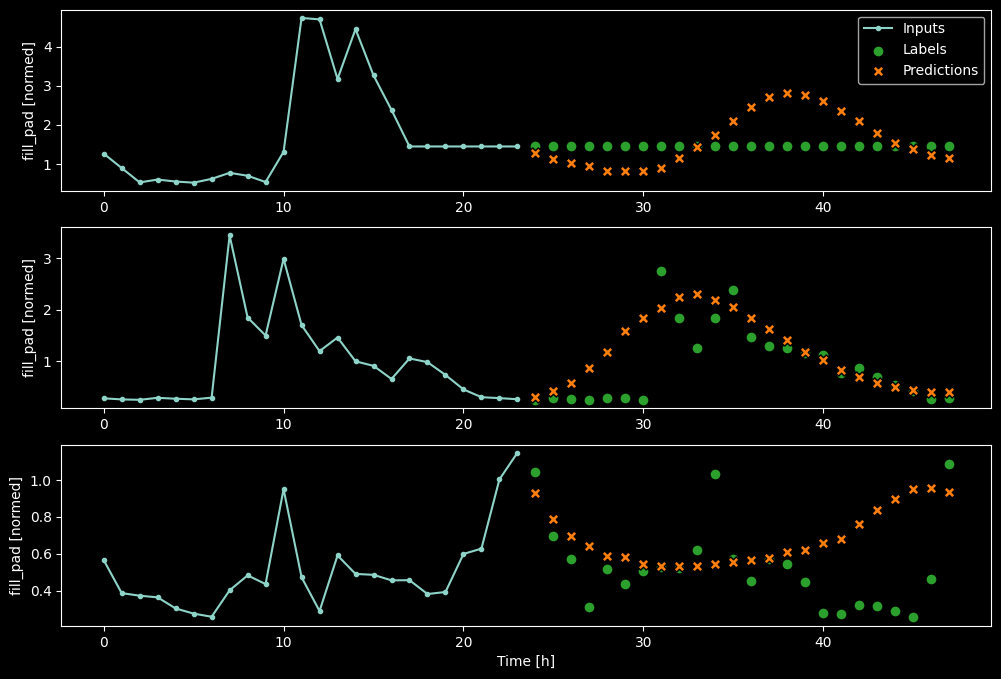

In [242]:
fill_pad_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

fill_pad_history = compile_and_fit(fill_pad_model, fill_ave_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = fill_ave_model.evaluate(fill_pad_window.val, return_dict=True)
multi_performance['LSTM'] = fill_ave_model.evaluate(fill_pad_window.test, verbose=0, return_dict=True)
fill_pad_window.plot(fill_ave_model)

223/223 [==============================] - 0s 929us/step - loss: 0.3935 - mean_absolute_error: 0.4017


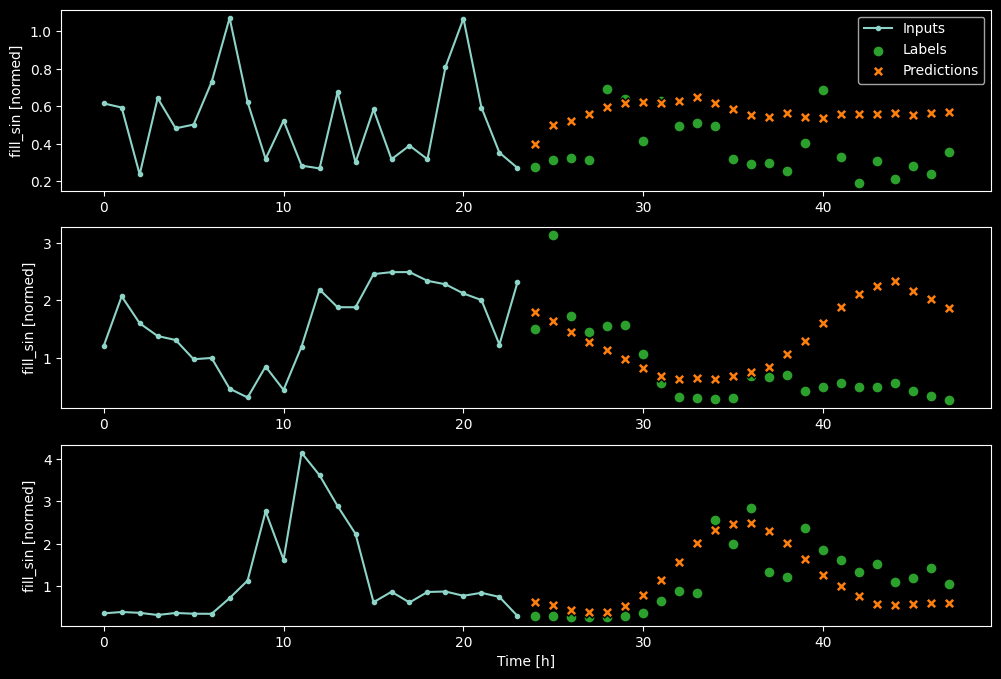

In [243]:
fill_sin_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

fill_sin_history = compile_and_fit(fill_sin_model, fill_sin_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = fill_sin_model.evaluate(fill_sin_window.val, return_dict=True)
multi_performance['LSTM'] = fill_sin_model.evaluate(fill_sin_window.test, verbose=0, return_dict=True)
fill_sin_window.plot(fill_sin_model)

In [57]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # self.lstm_cell = tf.keras.layers.LSTMCell(32)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

    print(f"Num features: {num_features}")

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

Num features: 1


TensorShape([32, 1])

In [58]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [59]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 1)


319/319 [==============================] - 0s 1ms/step - loss: 0.3966 - mean_absolute_error: 0.3988


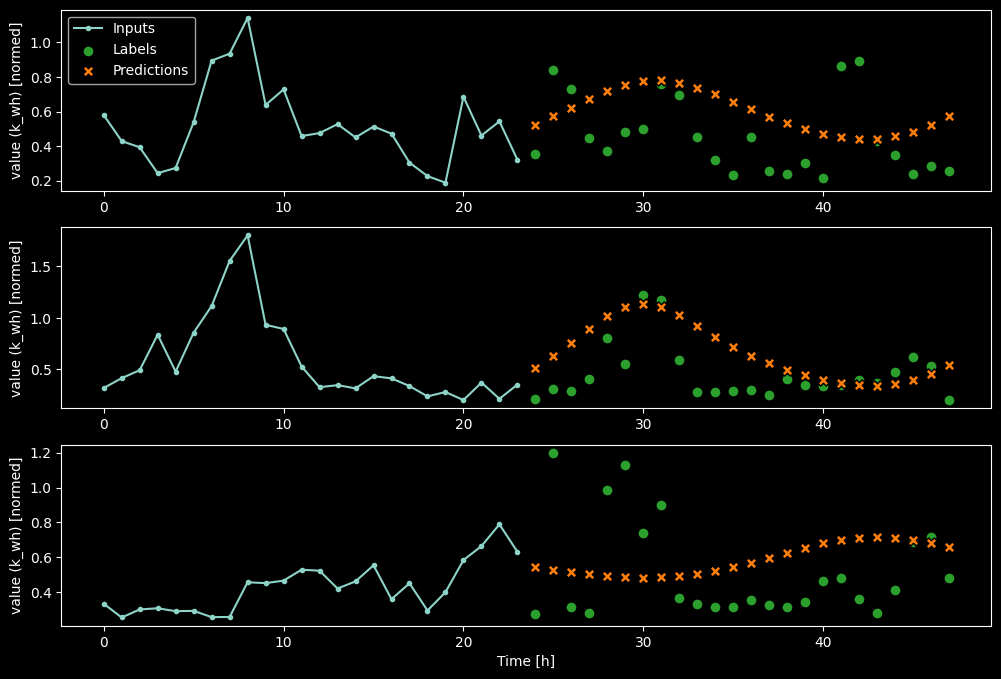

In [60]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)